<a href="https://colab.research.google.com/github/ulissigroup/Enabling-Robust-Offline-Active-Learning-for-MLPs/blob/master/terminal_scripts/Final_Code_NEB_FOR_PAPER_max_uncertainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/saurabhsivakumar/amptorch.git@active_learning
!pip install -q git+https://github.com/mshuaibii/SIMPLE-NN.git
!pip install -q amp-atomistics
!pip install -q --upgrade dftbook
import dftbook
dftbook.setup_colab()

     |████████████████████████████████| 296kB 5.2MB/s 
     |████████████████████████████████| 6.7MB 27.1MB/s 
     |████████████████████████████████| 102kB 13.4MB/s 
     |████████████████████████████████| 2.2MB 68.2MB/s 
     |████████████████████████████████| 12.8MB 91kB/s 
     |████████████████████████████████| 110.5MB 28kB/s 
     |████████████████████████████████| 512kB 58.3MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 3.8MB 61.2MB/s 
  ERROR: Failed building wheel for simple-nn
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatib

In [ ]:
!nvidia-smi

Mon Oct 26 22:11:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch.multiprocessing as mp

In [ ]:
import copy
import os
import numpy as np
import random

import torch

from amptorch.active_learning.learner import AtomisticActiveLearner
from amptorch.active_learning.query_methods import random_query, max_uncertainty
from amptorch.active_learning.al_utils import CounterCalc, attach_sp_calc
from amptorch.model import CustomMSELoss

import ase
from ase.calculators.calculator import Calculator
from ase.calculators.emt import EMT
from ase.calculators.singlepoint import SinglePointCalculator as sp
from ase.optimize import QuasiNewton
from ase.neb import NEB, SingleCalculatorNEB
from ase.optimize import BFGS, FIRE, BFGSLineSearch
from ase import Atoms, Atom, units
from ase.build import molecule
from ase.visualize import view
from ase.io import read, write
from ase.io.trajectory import TrajectoryReader,Trajectory
from ase.build import fcc100, add_adsorbate,bcc100,fcc111
from ase.constraints import FixAtoms
from ase.neb import NEBTools

import dftbook
dftbook.setup_colab()
from espresso import Espresso

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 

Please be patient. This takes about 30 seconds.
Installing ASE
Installing ase-espresso
Installing pseudopotentials
Renaming pseudopotentials
Almost there, setting environment pseudopotential path
Installing MKL
Getting the GPU pw.x executable
Done installing GPU version of Quantum Espresso
Setup is complete. Please visit https://github.com/jkitchin/dft-book-espresso to find the tutorials.
Installation took 18.7 seconds


In [ ]:
import ase
import json
import pdb
import copy
class NEBcalc:
    def __init__(self, starting_images, ml2relax=True, intermediate_samples=3):
        """
        Computes a NEB given an initial and final image.

        Parameters
        ----------
        starting_images: list. Initial and final images to be used for the NEB.

        ml2relax: boolean. True to use ML to relax the initial and final structure guesses. 
        False if initial and final structures were relaxed beforehand.
        
        intermediate_samples: int. Number of intermediate samples to be used in constructing the NEB"""
        
        self.starting_images = copy.deepcopy(starting_images)
        self.ml2relax = ml2relax
        self.intermediate_samples = intermediate_samples
    def run(self, calc, filename):
        """
        Runs NEB calculations.
        Parameters
        ----------
        calc: object. Calculator to be used to run method.
        filename: str. Label to save generated trajectory files."""
        
        initial = copy.deepcopy(self.starting_images[0])
        final = copy.deepcopy(self.starting_images[-1])
        if self.ml2relax:
            # Relax initial and final images
            ml_initial = initial
            ml_initial.set_calculator(calc)
            ml_final = final
            ml_final.set_calculator(calc)
            print('BUILDING INITIAL')
            qn = BFGS(ml_initial, trajectory='initial.traj', logfile='initial_relax_log.txt')
            qn.run(fmax=0.01, steps=100)
            print('BUILDING FINAL')
            qn = BFGS(ml_final, trajectory='final.traj', logfile='final_relax_log.txt')
            qn.run(fmax=0.01, steps=100)
            initial = ml_initial.copy()
            final = ml_final.copy()

        initial.set_calculator(calc)
        final.set_calculator(calc)

        images = [initial]
        for i in range(self.intermediate_samples):
            image = initial.copy()
            image.set_calculator(calc) 
            images.append(image)
        images.append(final)

        print('NEB BEING BUILT')
        neb = SingleCalculatorNEB(images)
        neb.interpolate()
        print('NEB BEING OPTIMISED')
        opti = BFGS(neb, trajectory=filename+".traj", logfile='al_neb_log.txt')
        opti.run(fmax=0.01, steps=100)
        print('NEB DONE')

        """ 
        The following code is used to visualise the NEB at every iteration 
        """
        
        built_neb = NEBTools(images)
        barrier, dE = built_neb.get_barrier()
        max_force = built_neb.get_fmax()
        fig = built_neb.plot_band()
        plt.show()
      
    def get_trajectory(self, filename):
        atom_list = []
        trajectory = ase.io.Trajectory(filename + ".traj")
        for atom in trajectory:
            atom_list.append(atom)
        return atom_list

In [ ]:
#https://wiki.fysik.dtu.dk/ase/tutorials/neb/diffusion.html#diffusion-tutorial
#Surface Diffusion Energy Barriers
#Building your structure
from amptorch.active_learning.atomistic_methods import Relaxation
def construct_geometries(parent_calc, ml2relax):
    counter_calc = CounterCalc(parent_calc,"parent_database")
    # Initial structure guess
    initial_slab = fcc100('Cu', size=(2, 2, 3))
    add_adsorbate(initial_slab, 'O', 1.7, 'hollow')
    initial_slab.center(axis=2, vacuum=4.0)
    mask = [atom.tag > 1 for atom in initial_slab]
    initial_slab.set_constraint(FixAtoms(mask=mask))

    initial_slab.set_calculator(counter_calc)

    # Final structure guess
    final_slab = initial_slab.copy()
    final_slab[-1].x += final_slab.get_cell()[0, 0] / 3
    final_slab.set_calculator(counter_calc)

    if not ml2relax:
        print('BUILDING INITIAL')
        qn = BFGS(initial_slab, trajectory='initial.traj', logfile='initial_relax_log.txt')
        qn.run(fmax=0.01, steps=100)
        print('BUILDING FINAL')
        qn = BFGS(final_slab, trajectory='final.traj', logfile='final_relax_log.txt')
        qn.run(fmax=0.01, steps=100)
        initial_slab = read("initial.traj", "-1")
        final_slab = read("final.traj", "-1")
        #If there is already a pre-existing initial and final relaxed parent state we can read that to use as a starting point
        #initial_slab = read("/content/parent_initial.traj")
        #final_slab = read("/content/parent_final.traj")
    else:
        initial_slab = attach_sp_calc(initial_slab)
        final_slab = attach_sp_calc(final_slab)

    initial_force_calls = counter_calc.force_calls
    return initial_slab, final_slab, initial_force_calls

In [ ]:
force_calls = []
def main():
    for i in range(5):
        base_calc = Espresso(pw=500.0, 
                    calculation='scf',
                    kpts=(4,4,1),
                    xc='PBE')
        #base_calc =EMT()
        # Define symmetry functions
        Gs = {}
        Gs["G2_etas"] = [0.005, 4.0, 20.0, 80.0]
        Gs["G2_rs_s"] = [0] * 4
        Gs["G4_etas"] = [0.005]
        Gs["G4_zetas"] = [1.0, 4.0]
        Gs["G4_gammas"] = [+1.0, -1]
        Gs["cutoff"] = 6.0

        ml2relax = True
        file_dir = f"./"
        os.chdir(file_dir)
        num_iter = 7
        samples = 3

        ml_training_params = {
                "al_convergence": {"method": "iter", "num_iterations": num_iter,'energy_tol':0.01,'convergence_check':True},
                "samples_to_retrain": samples,
                "Gs": Gs,
                "morse": True,
                "forcetraining": True,
                "cores": 1,
                "optimizer": torch.optim.LBFGS,
                "batch_size": 1000,
                "criterion": CustomMSELoss,
                "num_layers": 3,
                "num_nodes": 20,
                "force_coefficient": 0.04,
                "learning_rate": 1e-2,
                "epochs": 200,
                "test_split": 0,
                "shuffle": False,
                "verbose": 1,
                "filename": f"neb_max_uncertainty_ml2relax_true",
                "scheduler": {"policy": "CosineAnnealingWarmRestarts", "params":{"T_0":10, "T_mult":2}},
                "file_dir": "./"
        }
        initial, final, initial_force_calls = construct_geometries(parent_calc=base_calc, ml2relax=ml2relax)
        images = [initial]
        images.append(final)

        # Define AL scheme
        learner = AtomisticActiveLearner(
            training_data=images,
            training_params=ml_training_params,
            parent_calc=base_calc,
            convergence_func = 'neb_convergence',
            ensemble=2
        )

        # Learn the corresponding atomistic method
        learner.learn(
            atomistic_method=NEBcalc(
                starting_images=images, 
                ml2relax=ml2relax, 
                intermediate_samples=3),
            query_strategy=max_uncertainty
        )
        print(initial_force_calls+learner.parent_calls)
        force_calls.append(initial_force_calls+learner.parent_calls)

BUILDING INITIAL
BUILDING FINAL
NEB BEING BUILT
NEB BEING OPTIMISED
NEB DONE


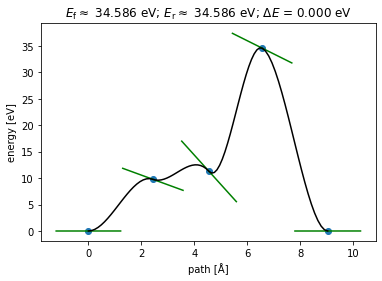

BUILDING INITIAL
BUILDING FINAL
NEB BEING BUILT
NEB BEING OPTIMISED
NEB DONE


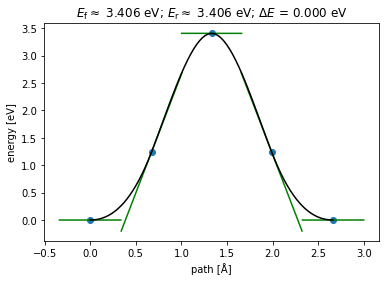

BUILDING INITIAL
BUILDING FINAL
NEB BEING BUILT
NEB BEING OPTIMISED
NEB DONE


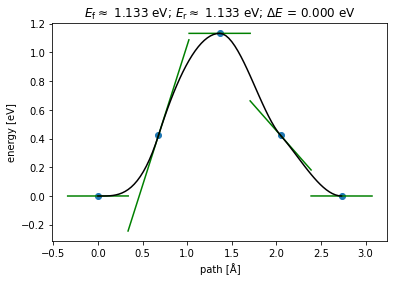

BUILDING INITIAL
BUILDING FINAL
NEB BEING BUILT
NEB BEING OPTIMISED
NEB DONE


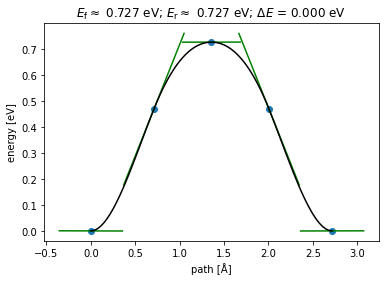

BUILDING INITIAL
BUILDING FINAL
NEB BEING BUILT
NEB BEING OPTIMISED
NEB DONE


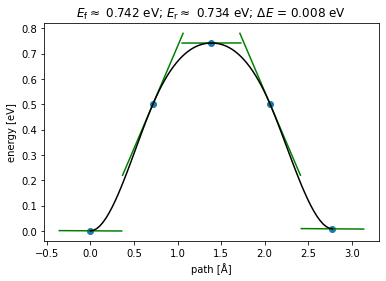

Terminating! Convergence criteria has been met


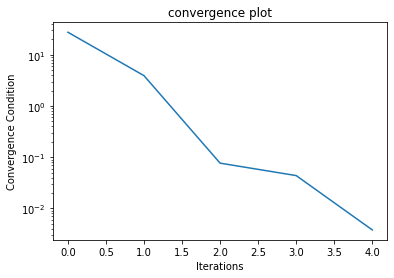

[27.612137725023786, 3.9174262262822594, 0.07659589279501233, 0.04379275711835362, 0.003802913925028406]
19
BUILDING INITIAL
BUILDING FINAL
NEB BEING BUILT
NEB BEING OPTIMISED
NEB DONE


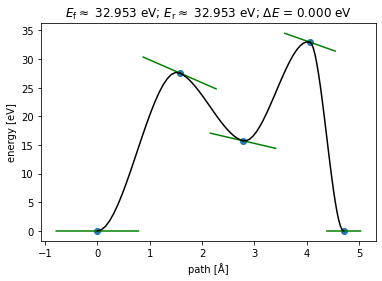

BUILDING INITIAL
BUILDING FINAL
NEB BEING BUILT
NEB BEING OPTIMISED
NEB DONE


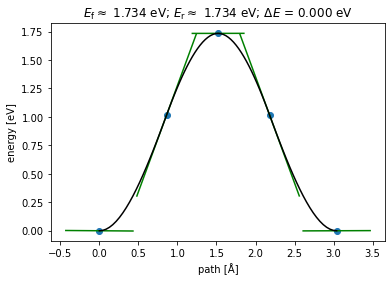

BUILDING INITIAL
BUILDING FINAL
NEB BEING BUILT
NEB BEING OPTIMISED
NEB DONE


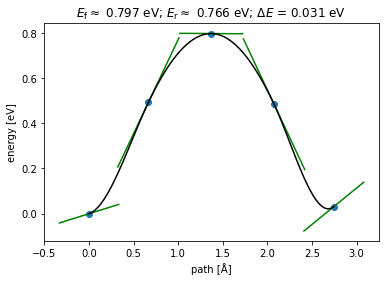

Terminating! Convergence criteria has been met


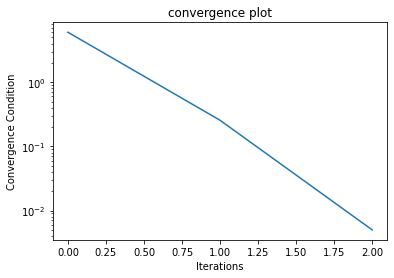

[6.014169990638038, 0.2550837221497204, 0.0049876493867486715]
11
BUILDING INITIAL
BUILDING FINAL
NEB BEING BUILT
NEB BEING OPTIMISED
NEB DONE


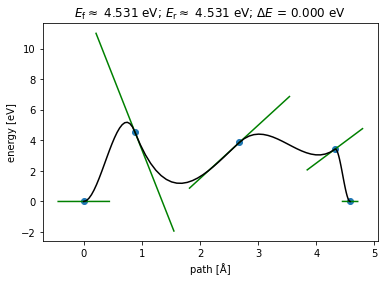

BUILDING INITIAL
BUILDING FINAL
NEB BEING BUILT
NEB BEING OPTIMISED
NEB DONE


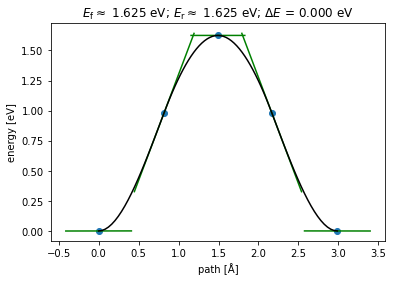

BUILDING INITIAL
BUILDING FINAL
NEB BEING BUILT
NEB BEING OPTIMISED
NEB DONE


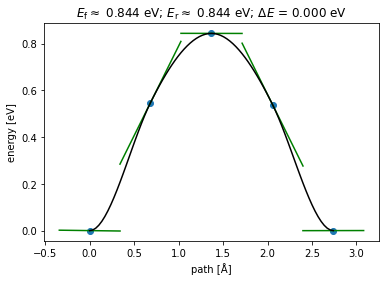

BUILDING INITIAL
BUILDING FINAL
NEB BEING BUILT
NEB BEING OPTIMISED
NEB DONE


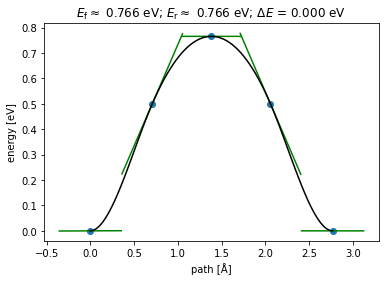

BUILDING INITIAL
BUILDING FINAL
NEB BEING BUILT
NEB BEING OPTIMISED
NEB DONE


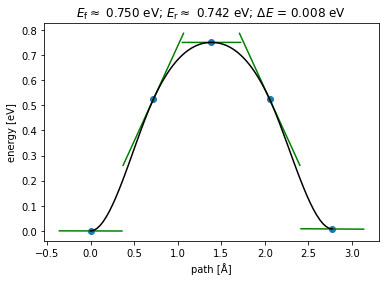

Terminating! Convergence criteria has been met


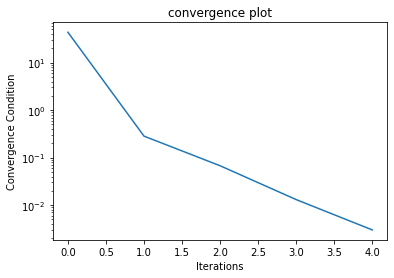

[43.654250888648676, 0.28355292265769094, 0.06752352815237828, 0.013085200800560415, 0.0030086426850175485]
19
BUILDING INITIAL
BUILDING FINAL
NEB BEING BUILT
NEB BEING OPTIMISED
NEB DONE


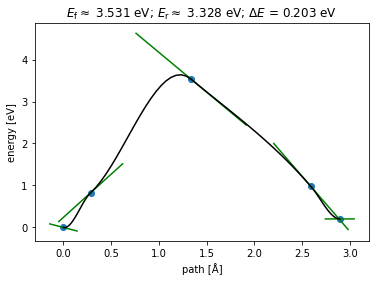

BUILDING INITIAL
BUILDING FINAL
NEB BEING BUILT
NEB BEING OPTIMISED
NEB DONE


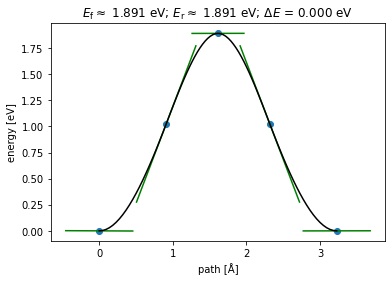

BUILDING INITIAL
BUILDING FINAL
NEB BEING BUILT
NEB BEING OPTIMISED
NEB DONE


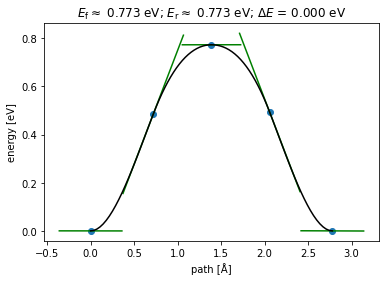

BUILDING INITIAL
BUILDING FINAL
NEB BEING BUILT
NEB BEING OPTIMISED
NEB DONE


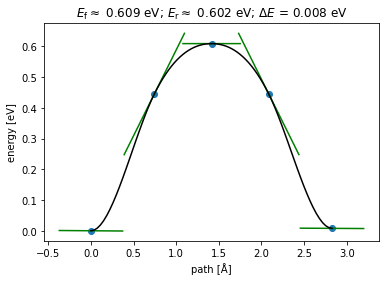

BUILDING INITIAL
BUILDING FINAL
NEB BEING BUILT
NEB BEING OPTIMISED
NEB DONE


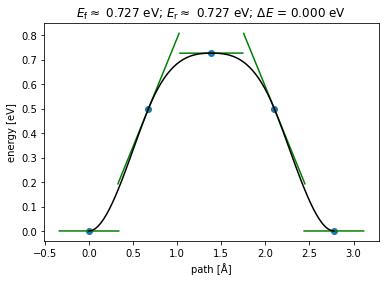

Terminating! Convergence criteria has been met


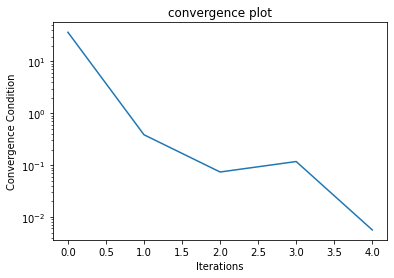

[36.55685068515595, 0.38523366970184725, 0.0737357692560181, 0.1173492625093786, 0.005631899781292304]
19
BUILDING INITIAL
BUILDING FINAL
NEB BEING BUILT
NEB BEING OPTIMISED
NEB DONE


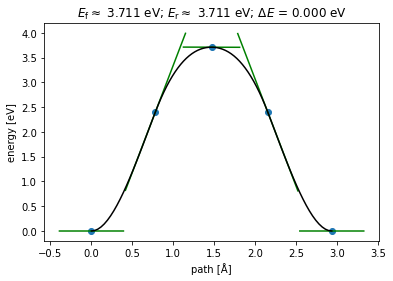

BUILDING INITIAL
BUILDING FINAL
NEB BEING BUILT
NEB BEING OPTIMISED
NEB DONE


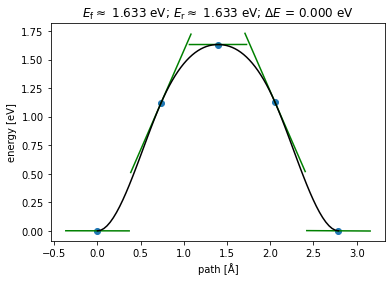

BUILDING INITIAL
BUILDING FINAL
NEB BEING BUILT
NEB BEING OPTIMISED
NEB DONE


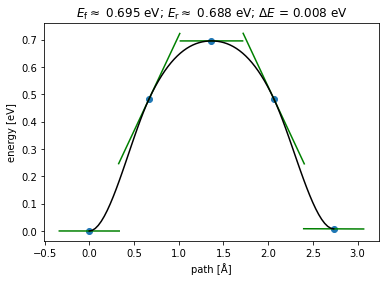

BUILDING INITIAL
BUILDING FINAL
NEB BEING BUILT
NEB BEING OPTIMISED
NEB DONE


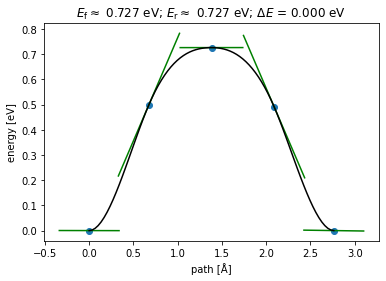

Terminating! Convergence criteria has been met


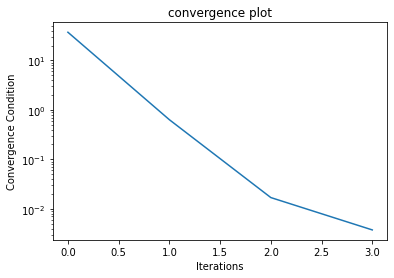

[37.1424072667578, 0.6335352935711853, 0.016890889455680735, 0.003747159702470526]
15


In [ ]:
if __name__ == "__main__":
  try:
    mp.set_start_method("spawn")
  except:
    if mp.get_start_method() == "spawn":
      pass
    else:
      raise Exception('Wrong mp start method!')
      
  main()